In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

from config import DSBConfig
import utils
from utils import DSBDataset
import mask_rcnn as modellib
import visualize
from mask_rcnn import log

Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

TRAIN_PATH = '../dataset/DSB/train/'
TEST_PATH = '../dataset/DSB/test/'

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
train_ids, val_ids = train_test_split(train_ids, test_size=0.1)

In [5]:
config = DSBConfig()
config.STEPS_PER_EPOCH  = len(train_ids)
config.VALIDATION_STEPS = len(val_ids)
config.IMAGE_MAX_DIM = 320
config.display()


Configurations:
BACKBONE_SHAPES                [[80 80]
 [40 40]
 [20 20]
 [10 10]
 [ 5  5]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  320
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           DSB
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000


In [6]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
# Training dataset
dataset_train = DSBDataset()
dataset_train.load_DSB(320, 320, train_ids, TRAIN_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = DSBDataset()
dataset_val.load_DSB(320, 320, val_ids, TRAIN_PATH)
dataset_val.prepare()

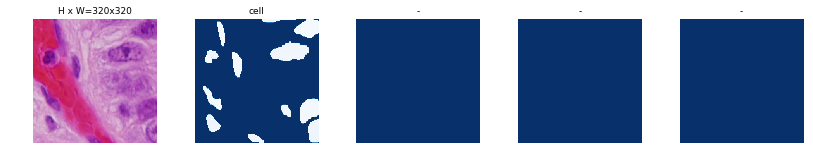

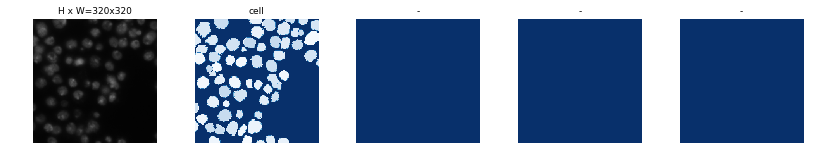

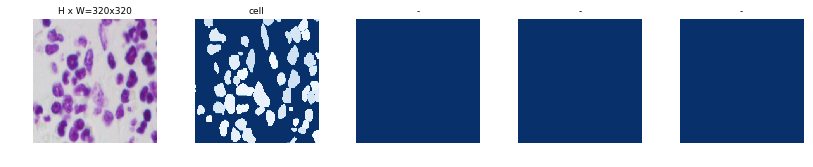

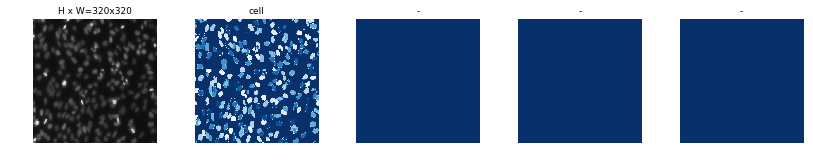

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [14]:
class InferenceConfig(DSBConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
inference_config = InferenceConfig()

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5


original_image           shape: (320, 320, 3)         min:    5.02734  max:   41.23047
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
gt_class_id              shape: (27,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (27, 4)               min:    0.00000  max:  320.00000
gt_mask                  shape: (320, 320, 27)        min:    0.00000  max:  255.00000


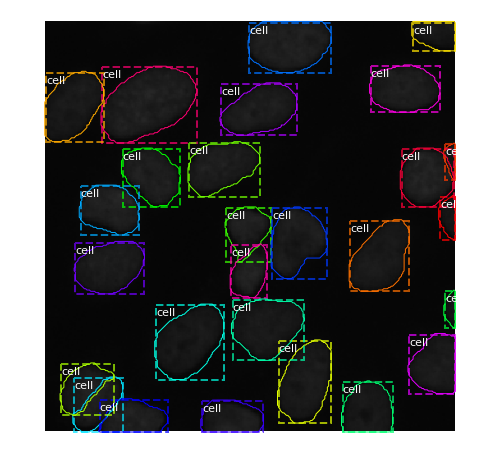

In [16]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(
    dataset_train,
    inference_config, 
    image_id,
    use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image,
    gt_bbox,
    gt_mask,
    gt_class_id, 
    dataset_train.class_names,
    figsize=(8, 8))

Processing 2 images
image                    shape: (320, 320, 3)         min:    5.02734  max:   41.23047
image                    shape: (320, 320, 3)         min:    5.02734  max:   41.23047
molded_images            shape: (2, 320, 320, 3)      min: -118.67266  max:  -62.66953
image_metas              shape: (2, 10)               min:    0.00000  max:  320.00000


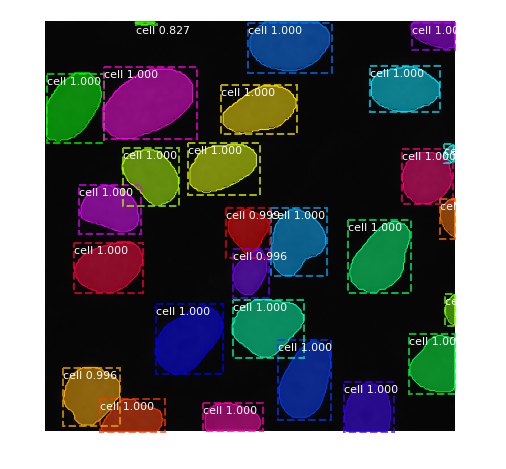

In [17]:
results = model.detect([original_image, original_image], verbose=1)

r = results[0]
visualize.display_instances(
    original_image,
    r['rois'],
    r['masks'],
    r['class_ids'], 
    dataset_val.class_names,
    r['scores'], ax=get_ax())